# Trends in Urban Heat Island Strength Across Major US Cities

### Load Data

In [1]:
# Setup
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
import pymannkendall as mk
from scipy.stats import pearsonr, spearmanr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
file_path = "/Users/Haley/atms523/ATMS-523-Module-8-Project/era5_tmean_jja_1950_2024.nc"

# open data
ds = xr.open_dataset(
    file_path,
    engine="netcdf4"
)

# rename t2m and time
ds = ds.rename({"t2m": "Tmean"})
ds = ds.rename({"valid_time":"time"})

print(ds)

<xarray.Dataset> Size: 108MB
Dimensions:    (time: 225, latitude: 211, longitude: 571)
Coordinates:
    number     int64 8B ...
  * time       (time) datetime64[ns] 2kB 1950-06-01 1950-07-01 ... 2024-08-01
  * latitude   (latitude) float64 2kB 51.0 50.9 50.8 50.7 ... 30.2 30.1 30.0
  * longitude  (longitude) float64 5kB -126.5 -126.4 -126.3 ... -69.6 -69.5
    expver     (time) <U4 4kB ...
Data variables:
    Tmean      (time, latitude, longitude) float32 108MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-06T21:17 GRIB to CDM+CF via cfgrib-0.9.1...


##### City Boundaries

In [ ]:
cities = {
    "New_York_City": {
        "lat_min": 40.4,
        "lat_max": 41.0,
        "lon_min": -74.3,
        "lon_max": -73.6,
    },
    "Chicago": {
        "lat_min": 41.6,
        "lat_max": 42.1,
        "lon_min": -88.1,
        "lon_max": -87.3,
    },
    "Los_Angeles": {
        "lat_min": 33.8,
        "lat_max": 34.3,
        "lon_min": -118.6,
        "lon_max": -118.0,
    },
    "Atlanta": {
        "lat_min": 33.5,
        "lat_max": 34.0,
        "lon_min": -84.7,
        "lon_max": -84.1,
    },
    "Seattle": {
        "lat_min": 47.45,
        "lat_max": 47.9,
        "lon_min": -122.5,
        "lon_max": -122.1,
    },
}

# Expansion degree for rural areas
expansion_deg = 1.0  

# baseline years
BASE_START = 1981 
BASE_END = 2010

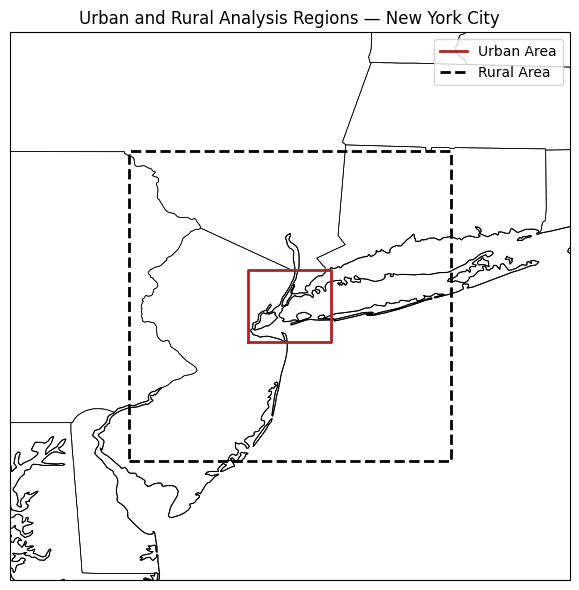

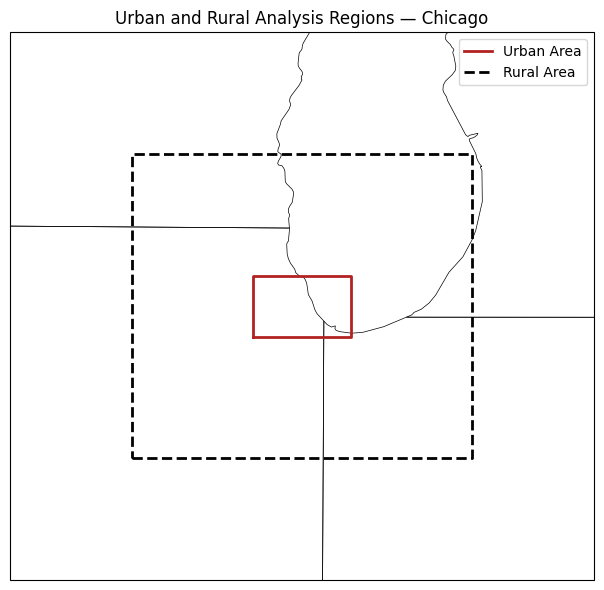

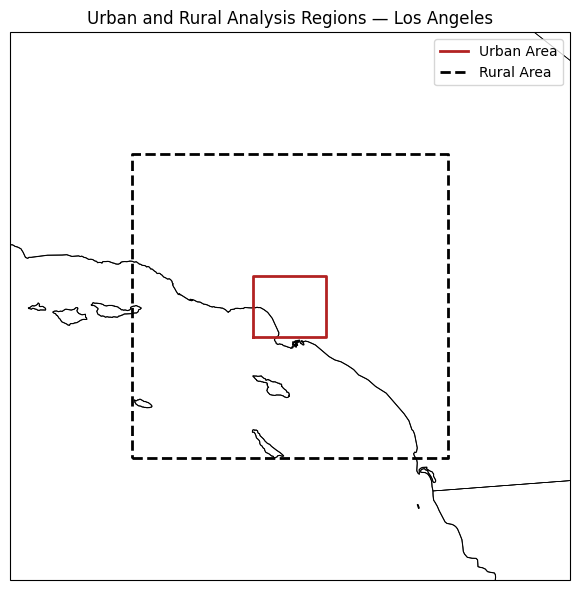

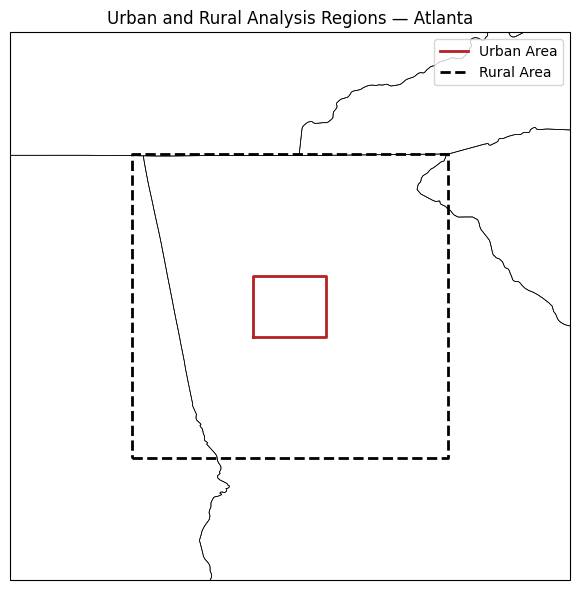

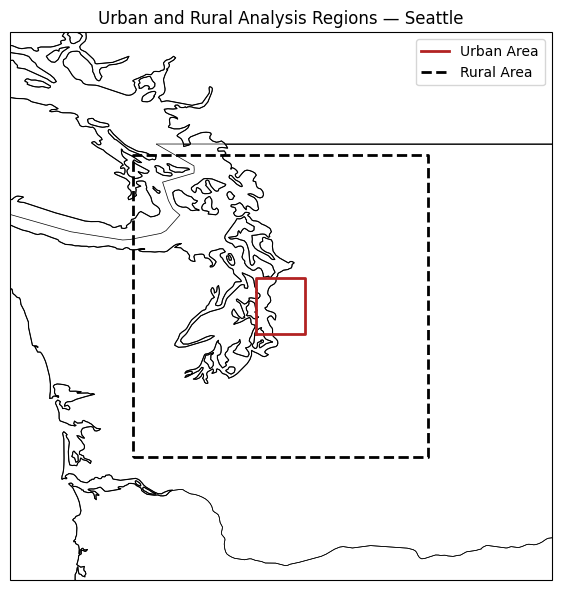

In [12]:
def plot_city_boundaries(cities, rural_expansion_deg=1.0):
    for city, cfg in cities.items():

        # Urban bounds
        lat_min = cfg["lat_min"]
        lat_max = cfg["lat_max"]
        lon_min = cfg["lon_min"]
        lon_max = cfg["lon_max"]

        # Rural bounds
        lat_min_ext = lat_min - rural_expansion_deg
        lat_max_ext = lat_max + rural_expansion_deg
        lon_min_ext = lon_min - rural_expansion_deg
        lon_max_ext = lon_max + rural_expansion_deg

        fig = plt.figure(figsize=(7,6))
        ax = plt.axes(projection=ccrs.PlateCarree())

        ax.set_extent(
            [lon_min_ext - 1, lon_max_ext + 1,
             lat_min_ext - 1, lat_max_ext + 1],
            crs=ccrs.PlateCarree()
        )

        ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, linewidth=0.5)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        # urban
        ax.plot(
            [lon_min, lon_max, lon_max, lon_min, lon_min],
            [lat_min, lat_min, lat_max, lat_max, lat_min],
            color="firebrick",
            linewidth=2,
            label="Urban Area",
            transform=ccrs.PlateCarree()
        )

        # rural
        ax.plot(
            [lon_min_ext, lon_max_ext, lon_max_ext, lon_min_ext, lon_min_ext],
            [lat_min_ext, lat_min_ext, lat_max_ext, lat_max_ext, lat_min_ext],
            color="black",
            linestyle="--",
            linewidth=2,
            label="Rural Area",
            transform=ccrs.PlateCarree()
        )

        ax.set_title(f"Urban and Rural Analysis Regions — {city.replace('_',' ')}")
        ax.legend(loc="upper right")
        plt.tight_layout()
        plt.show()

plot_city_boundaries(cities, rural_expansion_deg=expansion_deg)


### Monthly Mean Temperatures

In [29]:
# Function to compute monthly regional mean temperatures for urban and rural 
def compute_city_monthly_Tmean(ds,cities_dict,rural_expansion_deg=1.0,):
    lon_data_min = float(ds.longitude.min())
    out = []

    for city_name, cfg in cities_dict.items():
        print(f"Processing city: {city_name}")

        lat_min, lat_max = cfg["lat_min"], cfg["lat_max"]
        lon_min, lon_max = cfg["lon_min"], cfg["lon_max"]

        lon_min_ds, lon_max_ds = lon_min, lon_max

        # Expanded box for rural area
        lat_min_ext = lat_min - rural_expansion_deg
        lat_max_ext = lat_max + rural_expansion_deg
        lon_min_ext = lon_min_ds - rural_expansion_deg
        lon_max_ext = lon_max_ds + rural_expansion_deg

        lat0 = ds.latitude[0].item()
        lat_last = ds.latitude[-1].item()
        if lat0 > lat_last:
            lat_slice_ext = slice(lat_max_ext, lat_min_ext)
        else:
            lat_slice_ext = slice(lat_min_ext, lat_max_ext)

        lon_slice_ext = slice(lon_min_ext, lon_max_ext)

        # Subset to expanded box
        ds_box = ds.sel(latitude=lat_slice_ext, longitude=lon_slice_ext)

        # Build urban mask 
        city_lat_min, city_lat_max = sorted([lat_min, lat_max])
        city_lon_min, city_lon_max = lon_min_ds, lon_max_ds

        urban_mask = (
            (ds_box.latitude >= city_lat_min) &
            (ds_box.latitude <= city_lat_max) &
            (ds_box.longitude >= city_lon_min) &
            (ds_box.longitude <= city_lon_max)
        )
        rural_mask = ~urban_mask

        def simple_mean(da, mask):
            return da.where(mask).mean(dim=("latitude", "longitude"))

        urb_T = simple_mean(ds_box["Tmean"], urban_mask)
        rur_T = simple_mean(ds_box["Tmean"], rural_mask)

        out.append(
            xr.Dataset(
                {
                    "urban_Tmean": urb_T,
                    "rural_Tmean": rur_T,
                }
            ).assign_coords(city=city_name)
        )

    ds_out = xr.concat(out, dim="city")
    return ds_out


ds_city_monthly = compute_city_monthly_Tmean(ds,cities,rural_expansion_deg=expansion_deg,)

print(ds_city_monthly)



Processing city: New_York_City
Processing city: Chicago
Processing city: Los_Angeles
Processing city: Atlanta
Processing city: Seattle
<xarray.Dataset> Size: 15kB
Dimensions:      (city: 5, time: 225)
Coordinates:
    number       int64 8B 0
  * time         (time) datetime64[ns] 2kB 1950-06-01 1950-07-01 ... 2024-08-01
    expver       (time) <U4 4kB '0001' '0001' '0001' ... '0001' '0001' '0001'
  * city         (city) <U13 260B 'New_York_City' 'Chicago' ... 'Seattle'
Data variables:
    urban_Tmean  (city, time) float32 4kB 293.1 295.9 294.8 ... 293.1 291.7
    rural_Tmean  (city, time) float32 4kB 292.2 294.7 294.0 ... 291.3 289.6


In [30]:
# Aggregate to annual JJA mean temperatures

# Group by year 
ds_city_annual = ds_city_monthly.groupby("time.year").mean("time")
ds_city_annual = ds_city_annual.rename({"year": "year"})

print(ds_city_annual)

<xarray.Dataset> Size: 4kB
Dimensions:      (year: 75, city: 5)
Coordinates:
    number       int64 8B 0
  * city         (city) <U13 260B 'New_York_City' 'Chicago' ... 'Seattle'
  * year         (year) int64 600B 1950 1951 1952 1953 ... 2021 2022 2023 2024
Data variables:
    urban_Tmean  (year, city) float32 2kB 294.6 294.4 295.1 ... 299.2 290.9
    rural_Tmean  (year, city) float32 2kB 293.7 293.6 296.5 ... 299.3 288.7


Both urban and rural JJA mean temperatures show long term warming trends for all cities, where urban temperatures are generally warmer than nearby rural areas. The magnitude of the difference in urban and rural temperatures varies by city.

### 95th Percentile Thresholds

In [31]:
# compute 95th percentile thresholds for baseline years

def compute_jja_percentile_thresholds_all_years(ds_annual,base_start,base_end,percentile=95,):

    ds_base = ds_annual.sel(year=slice(base_start, base_end))

    q = percentile / 100.0

    urban_thresh = ds_base["urban_Tmean"].quantile(q, dim="year", skipna=True)
    rural_thresh = ds_base["rural_Tmean"].quantile(q, dim="year", skipna=True)

    thresholds = xr.Dataset(
        {
            "urban_thresh": urban_thresh,
            "rural_thresh": rural_thresh,
        }
    )

    return thresholds


thresholds_95 = compute_jja_percentile_thresholds_all_years(ds_city_annual,base_start=BASE_START,base_end=BASE_END,percentile=95,)

print(thresholds_95)



<xarray.Dataset> Size: 348B
Dimensions:       (city: 5)
Coordinates:
  * city          (city) <U13 260B 'New_York_City' 'Chicago' ... 'Seattle'
    quantile      float64 8B 0.95
Data variables:
    urban_thresh  (city) float64 40B 297.0 297.4 297.2 299.8 291.3
    rural_thresh  (city) float64 40B 296.1 296.8 298.3 299.5 289.2


In [32]:
# Find extreme years (mean > 95th percentile)
urban_thresh = thresholds_95["urban_thresh"]  
rural_thresh = thresholds_95["rural_thresh"] 

urban_exceed = ds_city_annual["urban_Tmean"] > urban_thresh
rural_exceed = ds_city_annual["rural_Tmean"] > rural_thresh

urban_extreme_year = urban_exceed.astype(int)
rural_extreme_year = rural_exceed.astype(int)

# Extreme years = 1
print("Urban extreme years")
print(urban_extreme_year)


Urban extreme years
<xarray.DataArray (year: 75, city: 5)> Size: 3kB
array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
...
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0

The 95th percentile thresholds are useful in determining a city specific definition of an above average summer based on the baseline conditions. The thresholds highlight the differences in climatology across cities, with warmer baseline thresholds in southern and western cities compared to northern cities. These thresholds provide a consistent reference for identifying relatively warm summers, while accounting for local climate differences between cities.

### UHI Index and Trends

In [33]:
# UHI index based on JJA mean 
uhi_JJA = ds_city_annual["urban_Tmean"] - ds_city_annual["rural_Tmean"]

def stl_decompose_annual(series, period=15):
    s = series.dropna("year").to_pandas()
    stl = STL(s, period=period, robust=True)
    result = stl.fit()
    return result

nyc_uhi = uhi_JJA.sel(city="New_York_City")
nyc_uhi_stl = stl_decompose_annual(nyc_uhi, period=15)

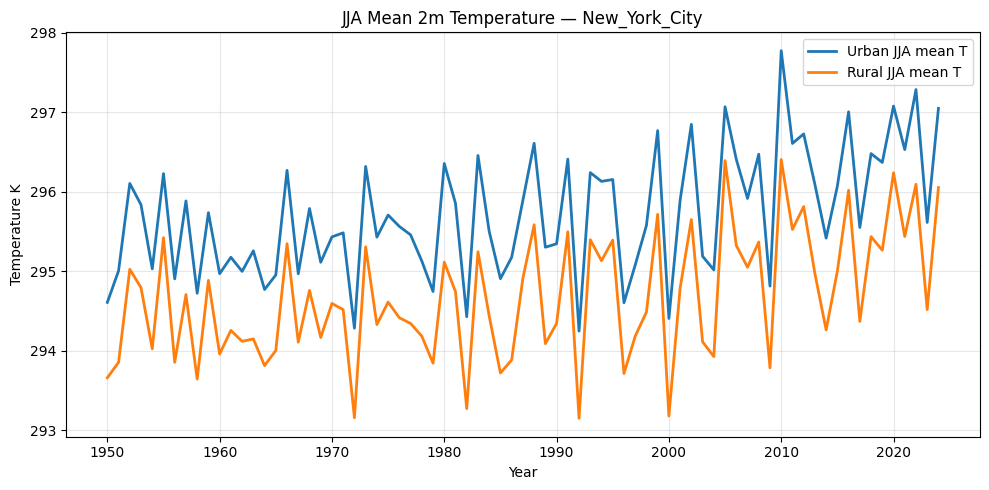

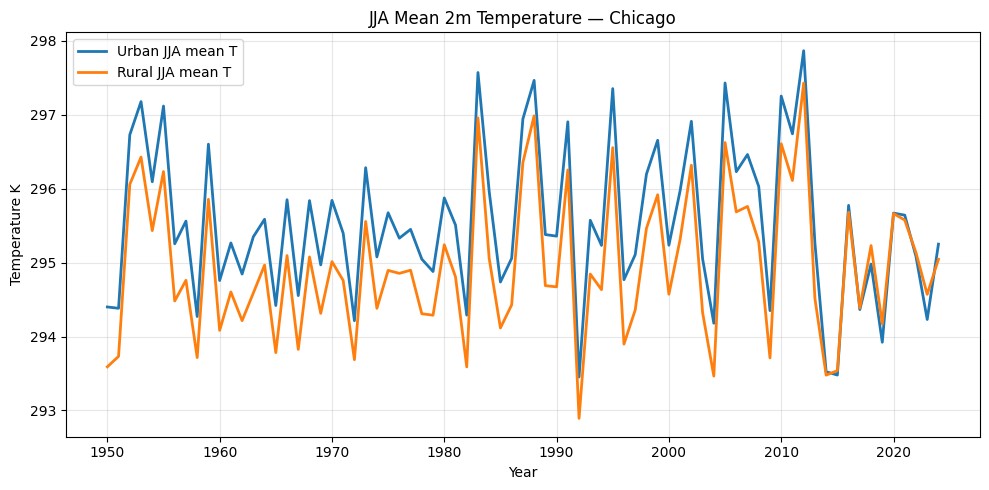

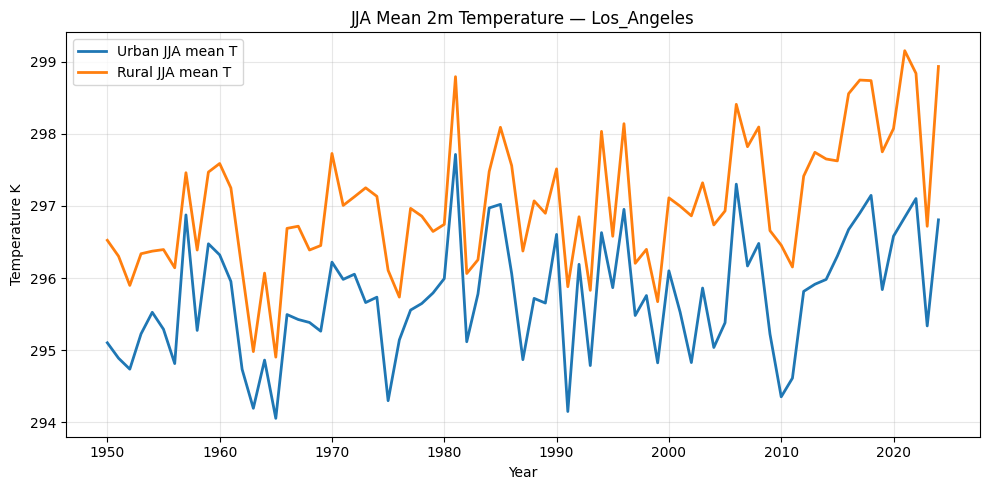

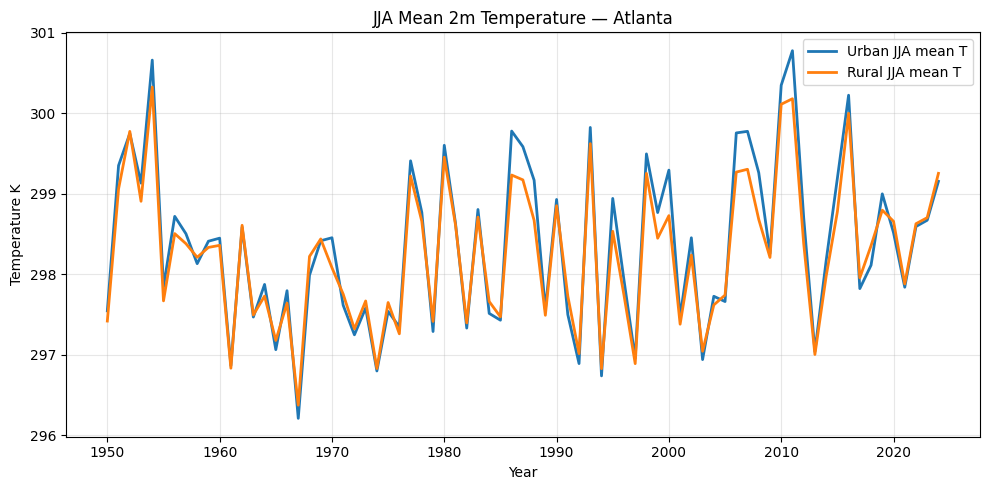

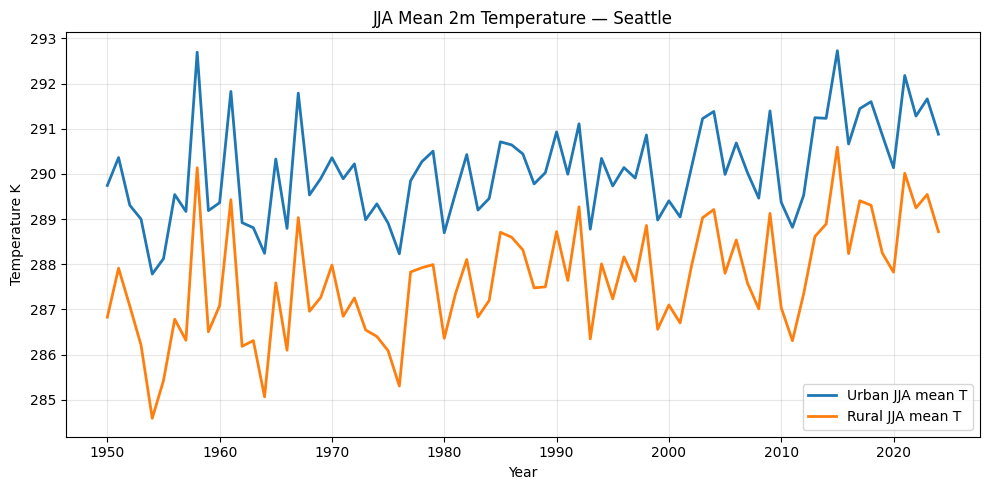

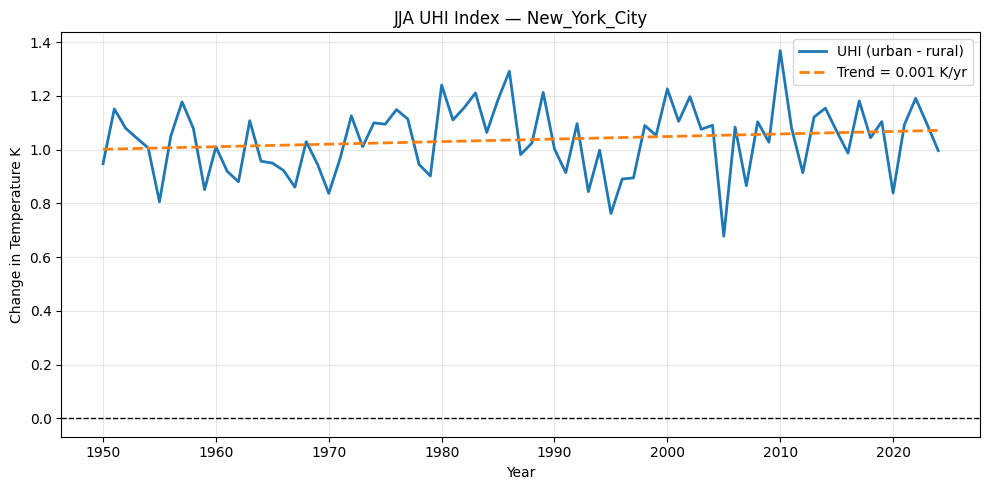

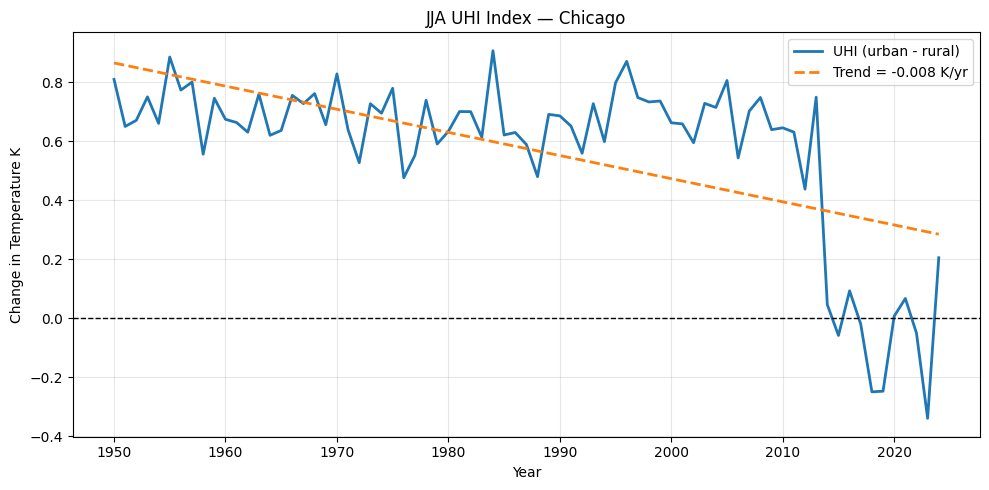

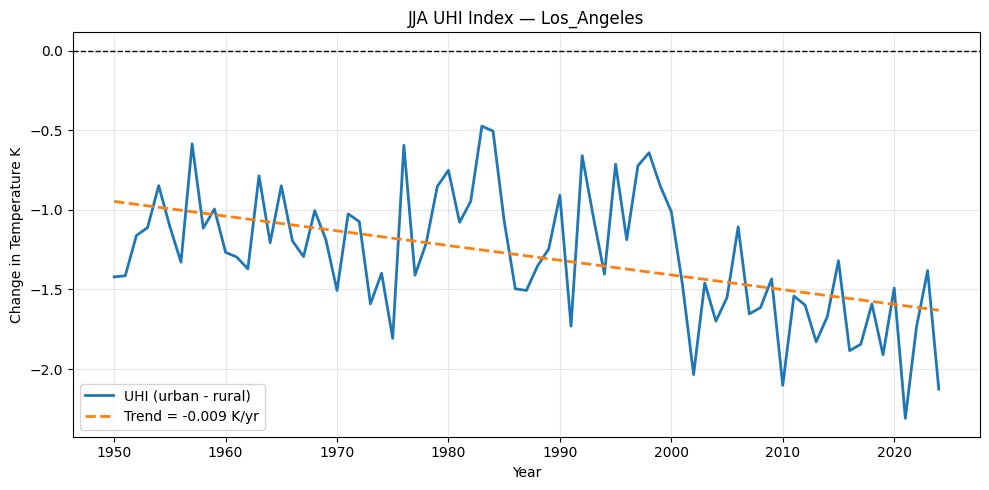

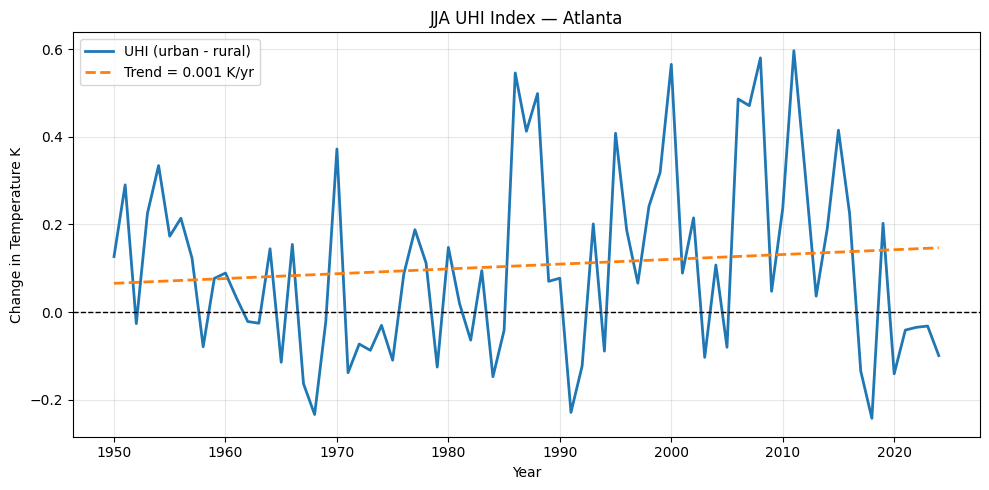

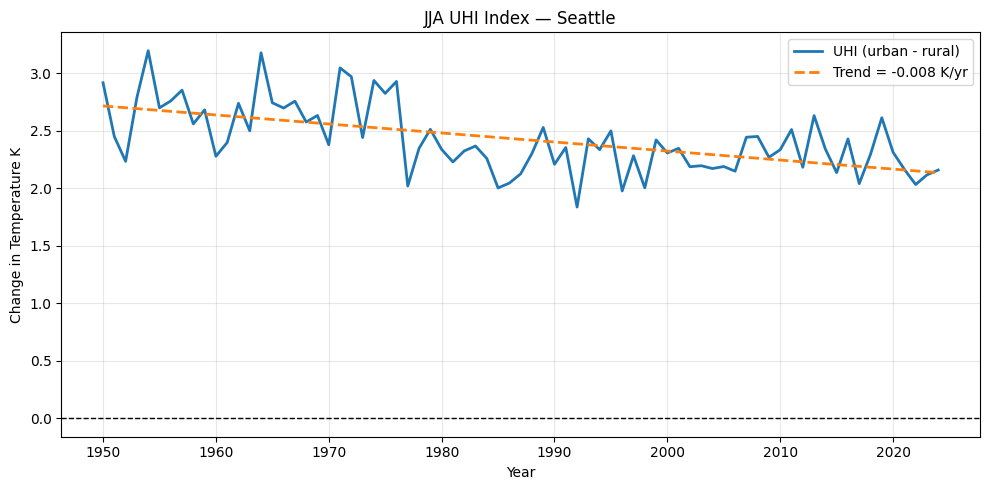

In [34]:
# Plot Time series of jja means
def plot_jja_mean_Tmean_urban_rural(ds_annual):
    for city in ds_annual.city.values:
        urb = ds_annual["urban_Tmean"].sel(city=city).to_pandas() #- 273.15 # Convert to C
        rur = ds_annual["rural_Tmean"].sel(city=city).to_pandas() #- 273.15

        plt.figure(figsize=(10,5))
        plt.plot(urb.index, urb.values, label="Urban JJA mean T", linewidth=2) #urban 
        plt.plot(rur.index, rur.values, label="Rural JJA mean T", linewidth=2) #rural

        plt.title(f"JJA Mean 2m Temperature — {city}")
        plt.xlabel("Year")
        plt.ylabel("Temperature K")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# plot UHI index
def plot_uhi_index(uhi_ds):
    for city in uhi_ds.city.values:
        series = uhi_ds.sel(city=city).to_pandas() 

        # Linear trend
        years = series.index.values
        coeffs = np.polyfit(years, series.values, deg=1)
        trend = np.polyval(coeffs, years)
        
        # Plot UHI
        plt.figure(figsize=(10,5))
        plt.plot(series.index, series.values, label="UHI (urban - rural)", linewidth=2)

        # Plot trend
        plt.plot(years,trend,linestyle="--",linewidth=2,label=f"Trend = {coeffs[0]:.3f} K/yr")

        plt.axhline(0.0, color="k", linewidth=1, linestyle="--")
        plt.title(f"JJA UHI Index — {city}")
        plt.xlabel("Year")
        plt.ylabel("Change in Temperature K")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()


plot_jja_mean_Tmean_urban_rural(ds_city_annual)
plot_uhi_index(uhi_JJA)

In [35]:
# Compute Mann-kendall and sens slope
def compute_trend_stats(ds_annual):

    results = []

    for city in ds_annual.city.values:
        urb = ds_annual["urban_Tmean"].sel(city=city).to_pandas()
        rur = ds_annual["rural_Tmean"].sel(city=city).to_pandas()
        uhi = urb - rur

        urb = urb.dropna()
        rur = rur.dropna()
        uhi = uhi.dropna()

        # Mann–Kendall
        mk_urb = mk.original_test(urb.values)
        mk_rur = mk.original_test(rur.values)
        mk_uhi = mk.original_test(uhi.values)

        # Sen slope 
        slope_urb = mk_urb.slope * 10
        slope_rur = mk_rur.slope * 10
        slope_uhi = mk_uhi.slope * 10

        results.append({
            "city": city,
            "urban_trend_K_per_decade": slope_urb,
            "urban_p_value": mk_urb.p,
            "rural_trend_K_per_decade": slope_rur,
            "rural_p_value": mk_rur.p,
            "uhi_trend_K_per_decade": slope_uhi,
            "uhi_p_value": mk_uhi.p,
        })

    return pd.DataFrame(results).set_index("city")


trend_table = compute_trend_stats(ds_city_annual)

trend_table


,urban_trend_K_per_decade,urban_p_value,rural_trend_K_per_decade,rural_p_value,uhi_trend_K_per_decade,uhi_p_value
city,,,,,,
New_York_City,0.186836,0.000012,0.182884,0.000055,0.010609,1.457731e-01
Chicago,-0.008105,0.905330,0.066235,0.260472,-0.035865,3.274892e-05
Los_Angeles,0.148533,0.001322,0.221200,0.000007,-0.088085,2.470286e-05
Atlanta,0.079922,0.181650,0.061831,0.125423,0.005756,6.672077e-01
Seattle,0.252720,0.000020,0.326609,0.000001,-0.074336,3.645145e-07


The Urban Heat Island (UHI) index is defined as the difference between urban and rural mean temperatures during the summer months. The UHI shows that long term trends in urban vs rural temperature differences are modest compared to the overall warming of both areas. Some cities show weak positive or negative trends over time, however year to year variability is high.

### UHI Trends vs Population Density Comparison

In [36]:
# Approximate population density - people/km^2
city_density = {
    "New_York_City": 11300,
    "Chicago": 3700,
    "Los_Angeles": 3200,
    "Atlanta": 1400,
    "Seattle": 3600,
}


In [37]:

mean_uhi = uhi_JJA.mean("year")

df_uhi_density = pd.DataFrame({
    "city": mean_uhi.city.values,
    "mean_UHI_K": mean_uhi.values,
    "population_density_km2": [
        city_density[city] for city in mean_uhi.city.values
    ],
}).set_index("city")

print(df_uhi_density)


               mean_UHI_K  population_density_km2
city                                             
New_York_City    1.036562                   11300
Chicago          0.574862                    3700
Los_Angeles     -1.288553                    3200
Atlanta          0.106171                    1400
Seattle          2.424807                    3600


In [38]:
uhi_vals = df_uhi_density["mean_UHI_K"]
density_vals = df_uhi_density["population_density_km2"]

# Pearson correlation
r_pearson, p_pearson = pearsonr(density_vals, uhi_vals)

# Spearman correlation
r_spearman, p_spearman = spearmanr(density_vals, uhi_vals)

print(f"Pearson r = {r_pearson:.2f}, p = {p_pearson:.3f}")
print(f"Spearman = {r_spearman:.2f}, p = {p_spearman:.3f}")


Pearson r = 0.26, p = 0.676
Spearman = 0.60, p = 0.285


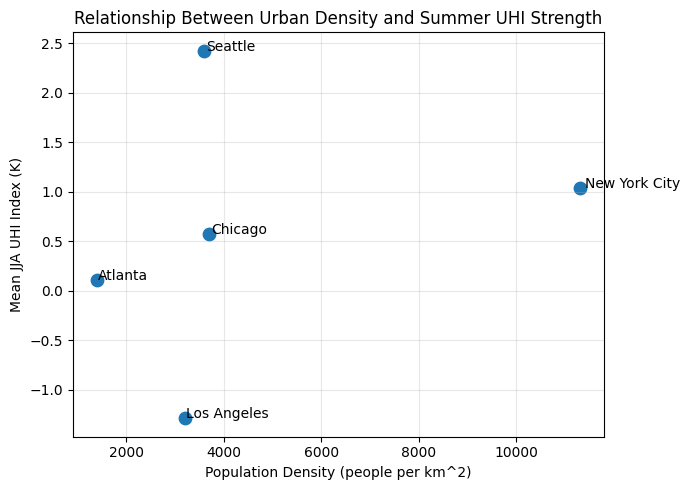

In [39]:
# Plot
plt.figure(figsize=(7,5))
plt.scatter(density_vals, uhi_vals, s=80)

for city in df_uhi_density.index:
    plt.text(
        df_uhi_density.loc[city, "population_density_km2"] * 1.01,
        df_uhi_density.loc[city, "mean_UHI_K"],
        city.replace("_", " "),
        fontsize=10,
    )

plt.xlabel("Population Density (people per km^2)")
plt.ylabel("Mean JJA UHI Index (K)")
plt.title("Relationship Between Urban Density and Summer UHI Strength")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Cities with higher population density, such as New York City, experience a larger mean UHI, which suggests there is a correlation between density and summer heat. However, since the sample size is so small, statistical significant is limited. 

### Early vs Late Periods Comparison

In [40]:
EARLY_START = 1950
EARLY_END   = 1979

LATE_START  = 1995
LATE_END    = 2024

# compute means
def compute_period_means(ds_annual, start_year, end_year):
    return ds_annual.sel(year=slice(start_year, end_year)).mean("year")

early_means = compute_period_means(ds_city_annual, EARLY_START, EARLY_END)
late_means  = compute_period_means(ds_city_annual, LATE_START, LATE_END)

early_uhi = early_means["urban_Tmean"] - early_means["rural_Tmean"]
late_uhi  = late_means["urban_Tmean"] - late_means["rural_Tmean"]


In [41]:
# Create summary table 
summary = []

for city in ds_city_annual.city.values:
    summary.append({
        "city": city,
        "urban_JJA_early_K": float(early_means["urban_Tmean"].sel(city=city)),
        "urban_JJA_late_K":  float(late_means["urban_Tmean"].sel(city=city)),
        "rural_JJA_early_K": float(early_means["rural_Tmean"].sel(city=city)),
        "rural_JJA_late_K":  float(late_means["rural_Tmean"].sel(city=city)),
        "uhi_early_K":       float(early_uhi.sel(city=city)),
        "uhi_late_K":        float(late_uhi.sel(city=city)),
        "uhi_change_K":      float(late_uhi.sel(city=city) - early_uhi.sel(city=city)),
    })

summary_df = pd.DataFrame(summary).set_index("city")
summary_df


,urban_JJA_early_K,urban_JJA_late_K,rural_JJA_early_K,rural_JJA_late_K,uhi_early_K,uhi_late_K,uhi_change_K
city,,,,,,,
New_York_City,295.327637,296.127228,294.326965,295.081085,1.000671,1.046143,0.045471
Chicago,295.406342,295.564941,294.715057,295.145172,0.691284,0.419769,-0.271515
Los_Angeles,295.399994,295.967010,296.566711,297.482819,-1.166718,-1.515808,-0.349091
Atlanta,298.092651,298.626892,298.042908,298.456970,0.049744,0.169922,0.120178
Seattle,289.632660,290.533417,286.965454,288.261169,2.667206,2.272247,-0.394958


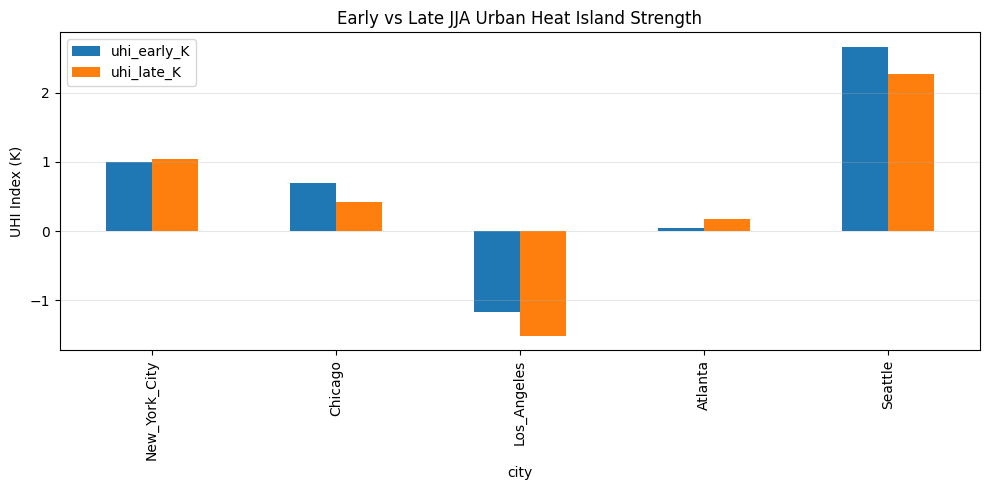

In [42]:
# plot mean UHI for early and late periods
def plot_early_late_uhi(summary_df):
    summary_df[["uhi_early_K", "uhi_late_K"]].plot(
        kind="bar",
        figsize=(10,5)
    )
    plt.ylabel("UHI Index (K)")
    plt.title("Early vs Late JJA Urban Heat Island Strength")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_early_late_uhi(summary_df)


By comparing early (1950–1979) and late (1995–2024) periods, it is clear that both rural and urban summer temperatures are increaing over time in all cities. Changes in UHI strength over time is relatively small compared to the overall warming. This indicates that warming is more strongly influenced by regional climate change than urbanization.